# <center><span style="color:#2C786C">2. 프로젝트: SentencePiece 사용하기</span></center>

## <span style="color:#F7B400">순서</span>
> **<span style="color:#2C786C">Step 1. SentencePiece 설치하기</span>**<br>
**<span style="color:#2C786C">Step 2. SentencePiece 모델 학습</span>**<br>
**<span style="color:#2C786C">Step 3. Tokenizer 함수 작성</span>**<br>
**<span style="color:#2C786C">Step 4. 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기</span>**<br>
**<span style="color:#2C786C">Step 5. 정리</span>**<br>
**<span style="color:#2C786C">Step 6. 루브릭 평가</span>**<br>
**<span style="color:#2C786C">Step 7. 회고</span>**

### <span style="color:#926DD6">참고</span>
>* [EXPLORATION_DJ 4. 영화리뷰 텍스트 감성분석하기]()
>* [딥 러닝을 이용한 자연어 처리 입문(wikidocs) : 네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis)](https://wikidocs.net/44249)

## <span style="color:#2C786C">Step 1. SentencePiece 설치하기</span>
---
SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 아래 링크의 페이지에서 상세한 내용을 파악할 수 있습니다.

* [google/sentencepiece](https://github.com/google/sentencepiece)

위 페이지의 서두에서도 언급하고 있듯, SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model들이 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준의 역할을 하고 있습니다. 앞으로의 실습 과정에서 자주 만나게 될 것이므로 꼭 친숙해지시기를 당부드립니다.

다음과 같이 설치를 진행합니다. SentencePiece는 python에서 쓰라고 만들어진 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있습니다.

    $ pip install sentencepiece

## <span style="color:#2C786C">Step 2. SentencePiece 모델 학습</span>
---
앞서 배운 **`tokenize()`** 함수를 기억하나요? 다시 한번 상기시켜드릴게요!

```{.python}
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer
```

위와 같이 **`tf.keras.preprocessing.text.Tokenizer`**에 corpus을 주고 **`tokenizer.fit_on_texts(corpus)`**을 하면 토크나이저 내부적으로 단어 사전과 토크나이저 기능을 corpus에 맞춤형으로 자동생성해 주는 것입니다.

그럼 이를 위해서 SentencePiece 모델을 학습하는 과정을 거쳐야 합니다.

In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [2]:
# 학습에 쓰인 데이터 : 한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 것
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


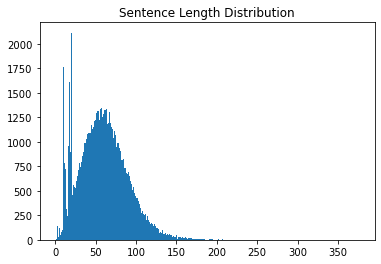

In [3]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

최단 길이 1, 최장 길이 377… 그리고 제법 그럴듯한 막대그래프가 나왔습니다만, 이 결과를 확인하고 드는 생각은 아래와 크게 다르지 않으실 거예요..!

*1) 길이 1 짜리 문장은 도대체 어떻게 생겨먹었지?*

*2) 앞에 치솟는 임의의 구간은 뭐지? 유의미한 데이터가 담겨있는 부분인가?*

*3) 어디서부터 어디까지 잘라서 쓰지?*

궁금증을 하나하나 해결해 봅시다! 대체 길이가 1인 문장은 뭘까요?

In [4]:
# 문장 길이별로 확인할 수 있는 함수를 정의
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


오잉? 하마터면 완전 노이즈인 데이터를 그대로 사용할 뻔했습니다! 왠지 길이별로 확인할 일이 많을 것 같아 함수를 미리 정의해두었는데, 이를 이용해 확인이 필요해 보이는 문장은 모두 확인해보죠.

In [5]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [6]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

In [7]:
check_sentence_with_length(raw, 19)

성공할 수 있는 일들이 있습니다."
두번째 목적은 상품을 파는 것이다.
그것들은 무엇을 하기 위한 것인가?
- 어째서 그렇게 대단한 것입니까?
불매운동가들의 시선을 끌고 싶은가?
그리고 우리는 계속해서 외식을 하며
(나는 그가 정직하다고 생각한다.)
박스데일도 동일한 기법을 사용한다.
"우리는 전속력으로 달려야 합니다.
수익은 연 25%씩 늘어나고 있다.
미국인 반체제 인사 해리 우의 운명
국가를 위해 좋은 일이 될 것이라고
무역 적자는 무역 흑자로 돌아섰으며
경찰에서조차 수사를 벌이고 있습니다
다음 번이 3월1일로 예정되어있다.
우리는 허구적인 시대에 살고 있다.
모 아니면 도였지요’’라고 말했다.
이씨는 짧았던 결혼을 세 번 했다.
하지만 성인이 되려면 아직 멀었다.
양국은 상호 3위의 교역상대국이다.
어떻게 지속적인 동기부여를 받느냐?
편지는 의사소통 이상의 일을 한다.
식량 부족으로 고통받는 북한 주민들
그는 뉴욕 금융지구에 살고 있었다.
6. “교회에 열심히 나가는가요?”
신문사가 발견된 기밀문서를 받았다.
3.인맥을 두루 갖춰놓지 못하는 것
15.면접 질문에 집중하지 않는 것
20.월급 이야기를 일찍 꺼내는 것
디아즈는 진지해지려고 하지 않는다.
전갈은 월마트 직원에 의해 잡혔다.
4.여성은 증상을 스스로 진단한다.
당시 휴스는 "나는 다스 베이더다!
회사에 대해 약간의 조사를 한다.:
스폰지에 물을 묻혀 청소해도 된다.
그러나 이를 뒷받침할 증거는 없다.
그는 올해 가을 손자를 보게 된다.
린은 칼을 이용해 쓰레기를 뒤진다.
거주지가 소아과 병원 인근일 경우.
언제든 메모해 두고 가지고 다닌다.
대법원의 심리는 6일부터 시작됐다.
* 원하는 가격에 흥정을 하는 방법
그는 치료 중이던 26일 사망했다.
무샤라프 대통령은 참석하지 않았다.
이미 경영진 2500명이 해임됐다.
스피처는 3명의 자녀를 두고 있다.
이들은 보통 10일 내로 사망한다.
그는 “왜 대통령이 되려 하느냐?”
* 뗏목, 카누등을 타고 구경할 때
유대인연합은 법원 결정을 환영했다.


In [8]:
check_sentence_with_length(raw, 21)

미국과 영국의 과학자들이 악수를 했다.
인력은 기계에 의해 보강되어야만 했다.
"시장은 그들에게 넓게 열려 있습니다.
아디다스는 또 다른 이점도 갖고 있다.
공부를 위해서만 이용하겠다고 말입니다.
환경법규의 도입은 고통스러운 과정이다.
- 여보, 이쪽이야, 아니면 저쪽이야?
인도는 훨씬 늦게 게임에 뛰어 들었다.
요즘 대부분의 기업들이 그렇지 않은가?
카리스마적인 지도자들은 위험을 즐긴다.
우리가 하려고 하는 일의 모델은 없다.
정상 회담은 오늘 늦게 끝날 것입니다.
그리고 공화당의 추정은 절반만 맞았다.
하지만 증가하고 있는 노인 인구수에따라
민간부문에서 그런 일을 할 수는 없다고
금년초 이라크 정보부는 "사담 후세인:
실제로 이 방법은 만족스럽지가 못하다.
카자흐스탄으로부터 중국으로 입국하려다가
클립퍼 칩에 대한 이야기로 들어 가자.
북한의 무기 개발에 대한 CIA 보고서
어려움을 겪고 있는 멕시코 경제에 대한
그는 ''미국은 우리의 최악의 적이다.
수로가 오염되고 야생동물이 밀렵되었다.
이런 지역들을 보살피고 보호해야 한다.
학습 방법은 훨씬 더 흠칫한 것입니다.
포옹은 심장에 좋은 약 일 수 도 있다
(경찰은 심문을 위해 그를 구금했다.)
금년에는 이 숫자가 58%로 증가했다.
(금고를 뒤져 많은 서류를 가져갔다.)
김치는 열량은 적고 비타민은 풍부하다.
smear campaign (흑색선전)
아들은 아버지로부터 사업을 이어받는다.
그것은 한계 효과가 나타나는 시기이다.
"사람들에게 선택권이 주어져야 합니다.
로야 저가는 임시 의사 결정 집단이다.
160석이 여성 대표들에게 보장되었다.
걷기 용으로 고안된 신발이 가장 좋다.
이것을 일주일에 5번 정도 해야 한다.
해외 판권은 이미 16개국에서 팔렸다.
그리고 나는 이렇게 엄숙히 서약합니다:
하지만 오늘의 주제를 그는 알것입니다:
(그 사건들은 전쟁 발발로 발전했다.)
"그는 정말로 국민들을 실망시켰습니다.
"제국의 반격"과 새 영화 "스타워즈:
남북간 해상 교전으로 남한 경비정 침몰
공룡들은 필연적으로

이런… 심지어 중복에 대한 처리도 제대로 하지 않았었네요. 중복 제거는 Python의 기본 자료형 **`set`**을 활용할 겁니다. **`set`**은 집합을 정의하는 자료형인데, 중복을 허용하지 않아 **변환 과정에서 자동으로 중복된 요소를 제거**해주거든요! 대신 **`list`**의 순서가 뒤죽박죽될 수 있으니, 만약 번역 데이터처럼 쌍을 이뤄야 하는 경우라면 주의해서 사용하셔야 합니다!

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


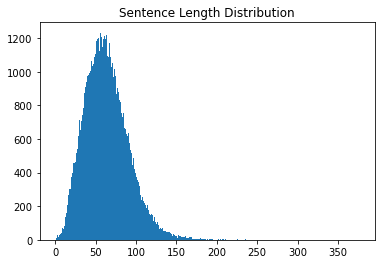

In [9]:
# 중복을 제거한 후, 앞에서 분포를 확인한 소스를 다시 실행
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

마지막으로 '모든 데이터를 다 사용할 것이냐' 가 문제인데, 후에 미니 배치를 만들 것을 생각하면 모든 데이터를 다 사용하는 것은 연산 측면에서 비효율적입니다. 미니 배치 특성상 각 데이터의 크기가 모두 동일해야 하기 때문에 가장 긴 데이터를 기준으로 Padding 처리를 해야 합니다.

길이별로 정렬하여 미니 배치를 구성해 Padding을 최소화하는 방법도 있지만 이는 데이터를 섞는 데 편향성이 생길 수 있으므로 지양해야 합니다. 여기서는 길이 150 이상의 데이터를 제거하고 사용하도록 할게요!

그리고 앞서 확인한 것처럼 너무 짧은 데이터는 오히려 노이즈로 작용할 수 있습니다. 따라서 길이가 10 미만인 데이터도 제거하도록 하죠!

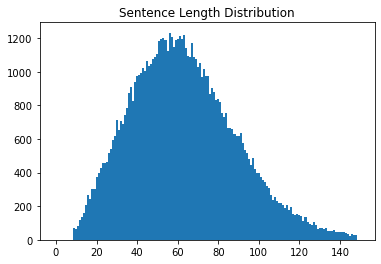

In [10]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [11]:
import sentencepiece as spm

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 376902  4월 25 03:12 korean_spm.model
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 146388  4월 25 03:12 korean_spm.vocab
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 413717  4월 25 00:31 korean_spm_10k.model
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 184956  4월 25 00:31 korean_spm_10k.vocab
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 317166  4월 25 00:32 korean_spm_5k.model
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49  83935  4월 25 00:32 korean_spm_5k.vocab
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 407852  4월 25 00:32 korean_spm_bpe_10k.model
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 149062  4월 25 00:32 korean_spm_bpe_10k.vocab
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 315042  4월 25 00:32 korean_spm_bpe_5k.model
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49  66253  4월 25 00:32 korean_spm_bpe_5k.vocab


위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후 koreanspm.model 파일과 koreanspm.vocab vocabulary 파일이 생성되었음을 확인할 수 있습니다.

그럼 이렇게 학습된 SentencePiece 모델을 어떻게 활용하는지 살펴보겠습니다.

In [12]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1244, 11, 306, 7, 3599, 11, 286, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


어떻습니까? SentencePiece의 토크나이징 실력이 괜찮은 것 같습니다.

## <span style="color:#2C786C">Step 3. Tokenizer 함수 작성</span>
---
우리는 위에서 훈련한 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 **`sp_tokenize()`** 함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하겠습니다.

>*1) 매개변수로 토큰화된 문장의 **`list`** 전달하는 대신 온전한 문장의 **`list`**를 전달합니다.*<br><br>
>*2) **생성된 vocab 파일**을 읽어와 **`{ <word> : <idx> }`** 형태를 가지는 **`word_index`** 사전과 **`{ <idx> : <word>}`** 형태를 가지는 **`index_word`** 사전을 생성하고 함께 **반환**합니다.*<br><br>
>*3) 반환값인 **`tensor`**는 앞의 함수와 같이 토큰화한 후 Encoding 된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?*<br>

In [13]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [14]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1949 5662    5    4 7975 1983    3    0    0    0    0    0    0    0]
 [ 107 1638  101    4    0  419   11    4   14    0 1969    3    3    3]]


## <span style="color:#2C786C">Step 4. 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기</span>
---
아마 여러분들은 [네이버 영화리뷰 감정분석 태스크](https://github.com/e9t/nsmc/)를 한 번쯤은 다루어 보았을 것입니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용했을 것입니다.

만약 이 문제에서 tokenizer를 sentencepiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? 비교해 보는 것도 흥미로울 것입니다.

>* 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용한 모델 학습하기
>*학습된 모델로 sp_tokenize() 메소드 구현하기
>*구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기
>*KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
>***(보너스)** SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기
>*Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.
>*머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것입니다.

**<span style="color:#124445">✓ 패키지(라이브러리)들을 import</span>**

In [15]:
import os
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import re

from konlpy.tag import Mecab
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

%matplotlib inline

print("import 완료!")

import 완료!


**<span style="color:#124445">✓ data load</span>**

In [16]:
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [17]:
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [18]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


**<span style="color:#124445">✓ 데이터 전처리 : 중복, 결측치 제거</span>**

In [19]:
train_data.drop_duplicates(subset=['document'], inplace=True)  # 데이터의 중복 제거 
train_data = train_data.dropna(how = 'any')  # NaN 결측치 제거 
test_data.drop_duplicates(subset=['document'], inplace=True)  # 데이터의 중복 제거 
test_data = test_data.dropna(how = 'any')  # NaN 결측치 제거 

In [20]:
print("data의 중복이 제거됐다면 False, 남아있다면 True로 출력됩니다.")
print("train_data :", train_data.isnull().values.any())
print("중복이 제거된 train_data의 수 :", len(train_data))
print("test_data :", test_data.isnull().values.any())
print("중복이 제거된 test_data의 수 :", len(test_data))
print("총 데이터의 수 :", len(train_data)+len(test_data))

data의 중복이 제거됐다면 False, 남아있다면 True로 출력됩니다.
train_data : False
중복이 제거된 train_data의 수 : 146182
test_data : False
중복이 제거된 test_data의 수 : 49157
총 데이터의 수 : 195339


In [21]:
raw = list(train_data['document']) + list(test_data['document'])
print("data size :", len(raw))
list(map(str, raw))

print("예시 :")
for sen in raw[0:100][::20]: print(">>", sen)

data size : 195339
예시 :
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..


문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


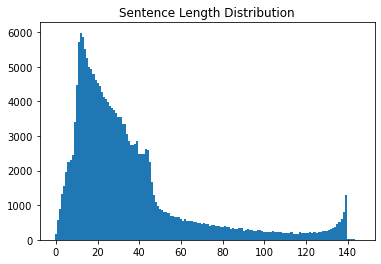

In [22]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [23]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 20: return

check_sentence_with_length(raw, 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬


대체로 별 의미 없는 평가네요!

In [24]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 5
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47


In [25]:
check_sentence_with_length(raw, 5)

재미있어요
전 좋아요
아 빵점~
ㅠㅠ 슬픔
최고의영화
잘봤습니다
쓰레기영화
볼만 한데
짝퉁쓰래기
잼없네요넘
재밌따!!
반지의제왕
ㅄ같은영화
옛다 평점
글쎄...
8점만들자
재밌군..
할말 없음
좋다...
좋았다..
시시하다.


In [26]:
check_sentence_with_length(raw, 47)

어린시절 너무 무섭고 재미있게 봤던 추억의 판타지영화.절대 나쁜짓은 금물.지옥가요..
진짜 한번만더 이런영화 상영하면 용서하지 않는다지금 영화보면서 카톡하고잇음 아놔 진짜
영화 첫 도입부 부터 카메라 각도라든지 화질이라든지 겁나 구림.. 영화 아닌줄 알았음
싸구려 왜색 영화, 키작고 교활한 일본원숭이들의 망상, 사무라이 정신..토나온다...
무슨 내용인지 도통 모르겠다... 쓸데없이 특별해 보이려는 시도에만 열중이었던 영화.
보지말아라 재미있든 재미없든 진짜 찝찝하고 기분 드러운 영화공포영화 싸이코 영화...
기존 한국 영화에서 느끼지 못한 색다른 느낌상업적이기 보다는 새로움에 도전한듯한 ..
오늘 아이데리고 봤는데...아이는 좋아하데요...ㅎㅎ 미취학, 초등 어린이에게 추천~
기방난동사건이후 최악의 영화 .재밌다는 사람들 믿고 봤더니 다 알바생인듯 ... ㅜㅜ
지금 첨봤는데 1회만 봐볼까하고 봤다가 주말 밤새완주하였다. 여운이 많이 남는 드라마
많이 알려지지 않은 작품인데 스탤론에 대해 관심을 있으면 한번쯤 보게될 수작 재난영화
출가 후 이 영화 첨으로 보았습니다. 김해 은하사 좋네요. 액션 코미디 재밌었습니다.
언론의 맹점과 군중심리. 개인의심리까지 파헤치면서도 재미까지 균형을 잘 맞춘 멋진영화
좋은소재 못 살린 OO 감독. 연출만 잘 했어도 대단한 영화가 되었을텐데...쯧쯧..
이런 영화를 볼 수 있어서 ... ㅠㅠ 이제 정말 아픔이 없었으면 좋겠는데 말이죠..
짱재밌다!!! 김지수, 이하나 ,한재석, 정겨운, 최정희 교수님 , 장태문 회장님 ,
진짜 유키스 동호 목소리 안좋다 배우 유선님은 목소리가 나레이션 성우 아나운서 같던데
스파이더맨을 가장 좋아하는 1人~ 스파이더맨 완전 사랑합니다. 영원했으면 좋겠네요!!
제니 라이트 존나 이쁘다 .... 제니 라이트 때매 10점 내 손가락도 주고싶다 ㅠㅠ
평점 남기기도 민망함~ 포스터가 맘에 들어서서 1점 줌~그냥 소소한 일상을 담은 영화
1점 2점 뭐냐 이명작을 ㄷㄷ... 1990년대 이정도퀼리티영화가 얼마나

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


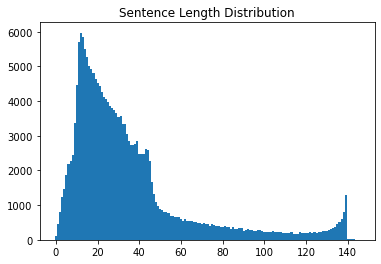

In [27]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

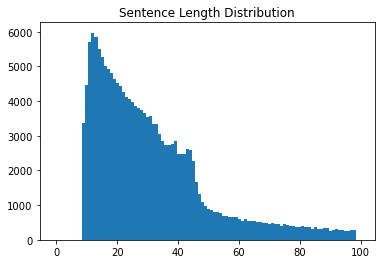

In [28]:
# 길이별로 정렬하여 제거
max_len = 100
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sen = str(sen)
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

**<span style="color:#124445">✓ SentencePiece 학습</span>**

In [29]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_10k --vocab_size={}'.format(temp_file, vocab_size)    
)
spm.SentencePieceTrainer.Train(
    '--input={} --model_type=bpe --model_prefix=korean_spm_bpe_10k --vocab_size={}'.format(temp_file, vocab_size)    
)
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_5k --vocab_size={}'.format(temp_file, vocab_size // 2)    
)
spm.SentencePieceTrainer.Train(
    '--input={} --model_type=bpe --model_prefix=korean_spm_bpe_5k --vocab_size={}'.format(temp_file, vocab_size // 2)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 376902  4월 25 03:12 korean_spm.model
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 146388  4월 25 03:12 korean_spm.vocab
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 414311  4월 25 03:12 korean_spm_10k.model
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 185523  4월 25 03:12 korean_spm_10k.vocab
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 317346  4월 25 03:13 korean_spm_5k.model
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49  84118  4월 25 03:13 korean_spm_5k.vocab
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 408278  4월 25 03:12 korean_spm_bpe_10k.model
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 149488  4월 25 03:12 korean_spm_bpe_10k.vocab
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49 315124  4월 25 03:13 korean_spm_bpe_5k.model
-rw-r--r-- 1 aiffel-dj49 aiffel-dj49  66335  4월 25 03:13 korean_spm_bpe_5k.vocab


**<span style="color:#124445">✓ 모델 성능 분석 : 간단한 LSTM 모델을 사용하여 SentencePiece와 Mecab을 비교 분석</span>**

In [30]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre',maxlen=80)

    return tensor, word_index, index_word

In [31]:
#sp_tokenize(s, corpus) 사용예제
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0 1949 5662    5    4 7975 1983    3]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  107 1638  101    4
     0  419   11    4   14    0 1969    3    3    3]]


In [32]:
s.Load('korean_spm.model')
train_test, word_index, index_word = sp_tokenize(s, raw)

In [33]:
train_test.shape

(195339, 80)

In [34]:
# 데이터 분할
X_train = train_test[:146182]
X_test = train_test[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 80)
(96182,)


**<span style="color:#124445">✓ 모델 만들기</span>**

In [35]:
vocab_size = 10000  # 어휘 사전의 크기입니다.
word_vector_dim = 200  # 워드 벡터의 차원수

# model 설계
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model1.add(keras.layers.Dense(10, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 10)                2010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,322,821
Trainable params: 2,322,821
Non-trainable params: 0
_________________________________________________________________


**<span style="color:#124445">✓ 모델 훈련 및 성능 평가 : SentencePiece</span>**

In [36]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
188/188 [==============================] - 12s 63ms/step - loss: 0.4668 - accuracy: 0.7764 - val_loss: 0.3955 - val_accuracy: 0.8220
Epoch 2/10
188/188 [==============================] - 11s 58ms/step - loss: 0.3751 - accuracy: 0.8329 - val_loss: 0.3770 - val_accuracy: 0.8310
Epoch 3/10
188/188 [==============================] - 11s 59ms/step - loss: 0.3410 - accuracy: 0.8501 - val_loss: 0.3694 - val_accuracy: 0.8363
Epoch 4/10
188/188 [==============================] - 11s 59ms/step - loss: 0.3145 - accuracy: 0.8634 - val_loss: 0.3621 - val_accuracy: 0.8403
Epoch 5/10
188/188 [==============================] - 11s 59ms/step - loss: 0.2900 - accuracy: 0.8755 - val_loss: 0.3768 - val_accuracy: 0.8392
Epoch 6/10
188/188 [==============================] - 11s 59ms/step - loss: 0.2704 - accuracy: 0.8855 - val_loss: 0.3750 - val_accuracy: 0.8373
Epoch 7/10
188/188 [==============================] - 11s 59ms/step - loss: 0.2495 - accuracy: 0.8959 - val_loss: 0.3896 - val_accuracy:

In [37]:
results = model1.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.4554 - accuracy: 0.8319
[0.45535749197006226, 0.8318652510643005]


In [38]:
def pipeline(spms, vocab):
    s = spm.SentencePieceProcessor()
    s.load(spms)
    train_test, word_index, index_word = sp_tokenize(s, raw)
    X_train = train_test[:146182]
    X_test = train_test[146182:]

    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))

    # validation set 50000건 분리
    x_val = X_train[:50000]   
    y_val = y_train[:50000]

    # validation set을 제외한 나머지 
    partial_X_train = X_train[50000:]  
    partial_y_train = y_train[50000:]
    
    vocab_size = vocab    # 어휘 사전의 크기입니다.
    word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

    # model 설계
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
    model.add(keras.layers.Dense(10, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.summary()
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

    epochs=10 

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    results = model.evaluate(X_test,  y_test, verbose=2)
    print(results)
    return history

In [39]:
pipeline('korean_spm_5k.model',5000)
pipeline('korean_spm_bpe_5k.model',5000)
pipeline('korean_spm_bpe_10k.model',10000)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,322,821
Trainable params: 1,322,821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
188/188 [==============================] - 11s 57ms/step - loss: 0.5510 - accuracy: 0.7717 - val_loss: 0.4912 - val_accuracy: 0.8325
Epoch 2/10
188/188 [==============================] - 10s 55ms/step - loss: 0.4676 - accuracy: 0.8

**<span style="color:#124445">✓ 모델 훈련 및 성능 평가 : Mecab 모델</span>**

In [40]:
# using konlpy
from konlpy.tag import Mecab
tokenizer = Mecab()
#미리 정의한 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] 
num_words = 10000

# 함수 기능
# 데이터의 중복 제거   
# NaN 결측치 제거   
# 한국어 토크나이저로 토큰화   
# 불용어(Stopwords) 제거   
# 사전word_to_index 구성   
# 텍스트 스트링을 사전 인덱스 스트링으로 변환   
# X_train, y_train, X_test, y_test, word_to_index 리턴   
def load_data(train_data, test_data, num_words=num_words):
    # 중복, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    # 사전 구성
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    # 변환 text to index
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [41]:
# index to text 사전
index_to_word = {index:word for word, index in word_to_index.items()}

In [42]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [43]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 한다  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [44]:
# 패딩 추가 (using keras.preprocessing.sequence.pad_sequences)
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [45]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,322,417
Trainable params: 2,322,417
Non-trainable params: 0
_________________________________________________________________


In [46]:
# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [47]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
188/188 [==============================] - 7s 39ms/step - loss: 0.4267 - accuracy: 0.7975 - val_loss: 0.3486 - val_accuracy: 0.8475
Epoch 2/10
188/188 [==============================] - 7s 38ms/step - loss: 0.3170 - accuracy: 0.8654 - val_loss: 0.3346 - val_accuracy: 0.8538
Epoch 3/10
188/188 [==============================] - 7s 39ms/step - loss: 0.2767 - accuracy: 0.8825 - val_loss: 0.3365 - val_accuracy: 0.8564
Epoch 4/10
188/188 [==============================] - 7s 39ms/step - loss: 0.2415 - accuracy: 0.8990 - val_loss: 0.3570 - val_accuracy: 0.8568
Epoch 5/10
188/188 [==============================] - 7s 39ms/step - loss: 0.2108 - accuracy: 0.9127 - val_loss: 0.3636 - val_accuracy: 0.8550
Epoch 6/10
188/188 [==============================] - 8s 40ms/step - loss: 0.1863 - accuracy: 0.9244 - val_loss: 0.3999 - val_accuracy: 0.8497
Epoch 7/10
188/188 [==============================] - 8s 40ms/step - loss: 0.1637 - accuracy: 0.9337 - val_loss: 0.4349 - val_accuracy: 0.8509

In [48]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.5658 - accuracy: 0.8412
[0.5657880306243896, 0.8412026762962341]


## <span style="color:#2C786C">Step 5. 정리</span>
---
>* SentencePiece 모델의 accuracy : 0.8319
>* Mecab 모델의 accuracy : 0.8412

둘 다 거의 차이가 없군요!

## <span style="color:#2C786C">Step 6. 루브릭 평가</span>
---

|평가문항|상세기준|
|-------|--------|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교·분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|

## <span style="color:#2C786C">Step 7. 회고</span>
---
첫 번째 고잉디퍼 과제인 만큼 새로운 마음가짐으로 임하였습니다.😊<br>
같은 관심사로 공부하는 사람들끼리 모이니 렉쳐 학습할 때도 즐거웠습니다.<br>
더불어 개인적으로 과거에 제대로 하지 못했던 익스도 같이 복습하는 시간을 가져볼 수 있어 좋았습니다.<br>
다만 에포크 돌릴 때 끼릭끼릭 소리나는데 왜그런지 잘 모르겠습니다.🤔<br>
2주의 시간이라 넉넉할 줄 알았는데 조삼모사였다는 깨달음을 얻어 남은 프로젝트는 서둘러 마무리 져야겠어요.😭😭😭😭😭😭😭

---